In [1]:
#Import Packages 
import xarray as xr
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import os 
import metpy 
import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units 
from IPython.display import HTML, display 
import imageio
from tqdm import tqdm
from itertools import product
import wrf 
import glob 
from scipy.interpolate import RegularGridInterpolator, interp1d
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

Cannot import USCOUNTIES and USSTATES without Cartopy installed.


In [2]:
#Create Path For Data Collection and Create A List of File Names
storm16_data_path = '/storage/work/bsh5393/storm16/'
storm16_files = os.listdir(storm16_data_path)

#Remove Unneccessary Files From Storm 16 File List
storm16_files.remove('README-TIMELEVELS')
storm16_files.remove('namelist.input')
storm16_files.remove('runstorm16.pbs.o44255112')
storm16_files.remove('cm1out_stats.nc')

In [4]:
#Step 1: Initialization and Input Parameters

#Data at t = 2hrs
storm_data = xr.open_dataset(storm16_data_path + storm16_files[1])

#Dataset Domain Size
ni = storm_data['ni']
nj = storm_data['nj']
nk = storm_data['nk']

#Datapoint Locations
x_data = storm_data['xh']*units.kilometer
y_data = storm_data['yh']*units.kilometer
z_data = storm_data['z']*units.kilometer

#Grid Locations (n+1)
x_grid = storm_data['xf']*units.kilometer
y_grid = storm_data['yf']*units.kilometer
z_grid = storm_data['zf']*units.kilometer

#Create New Lower/Upper Bound Variables Since We are not in the center of the domain anymore
lower_bound_x = np.abs(x_data.values + 12.5).argmin()-2
upper_bound_x = np.abs(x_data.values - 12.5).argmin()
lower_bound_y = np.abs(y_data.values + 45).argmin()
upper_bound_y = np.abs(y_data.values + 20).argmin()+2
horiz_length = upper_bound_y-lower_bound_y

#Grid Size 
size_x = size_y = upper_bound_x-lower_bound_x
size_z = len(z_data)

#Grid Spacing 
dx = x_data[1].values - x_data[0].values
dy = y_data[1].values - y_data[0].values
dz = np.zeros(len(z_data))
dz[0] = z_data[0].values
dz[1:] = z_data[1:].values-z_data[0:-1].values

#Time Intervals of Data
time = []
for x in np.arange(1,len(storm16_files),1):
    t = xr.open_dataset(storm16_data_path + storm16_files[x])['time']
    time.append(t)    
time = (np.asarray(time)*10**-9).reshape(len(time))
time = time.astype('int')
time = time - time[0]+30 #time elapsed in seconds (useful for interpolation later on)

#Time Intervals of Interpolation (We want every 10 seconds)
int_time = np.arange(int(time[0]), int(time[-1]), 10)
nanal = len(int_time) #Number of Trajectory Points 
dt = int_time[1]-int_time[0]

#Input Parameters 
asc_rate = 5 #3 m/s ascent rate of balloon

# Box & Whisker Plots and Correlation Matrix: PseudoData

In [5]:
#Load The pseudo_data

path = '/storage/work/bsh5393/Masters Thesis/Near-Storm PseudoSoundings/Data/'
pseudo_data = np.load(path+'pseudodata_2_cm1grid.npz')
points_data = np.load(path+'instantaneous_data.npz')


#Data Interpolated to Model Grid
P = pseudo_data['P']
T = pseudo_data['T']
Th = pseudo_data['Th']
Td = pseudo_data['Td']
qv = pseudo_data['qv']
u = pseudo_data['u']
v = pseudo_data['v']
w = pseudo_data['w']
zvort = pseudo_data['zvort']
parc_T = pseudo_data['parc_T']
CAPE = pseudo_data['CAPE']
CIN = pseudo_data['CIN']
SRH1km = pseudo_data['SRH1km']
SRH3km = pseudo_data['SRH3km']

#Original Trajectory Points
# points = pseudo_data['interp_points']

#Ground Relative Winds
offset_u = 12.2 
offset_v = 12.5 
gr_u = u[0] + offset_u
gr_v = v[0] + offset_v
gr_wind = np.sqrt((gr_u**2)+(gr_v**2)) 

Text(0.5, 1.0, 'WV Mixing Ratio @ z = 7.5 m (kg/kg)')

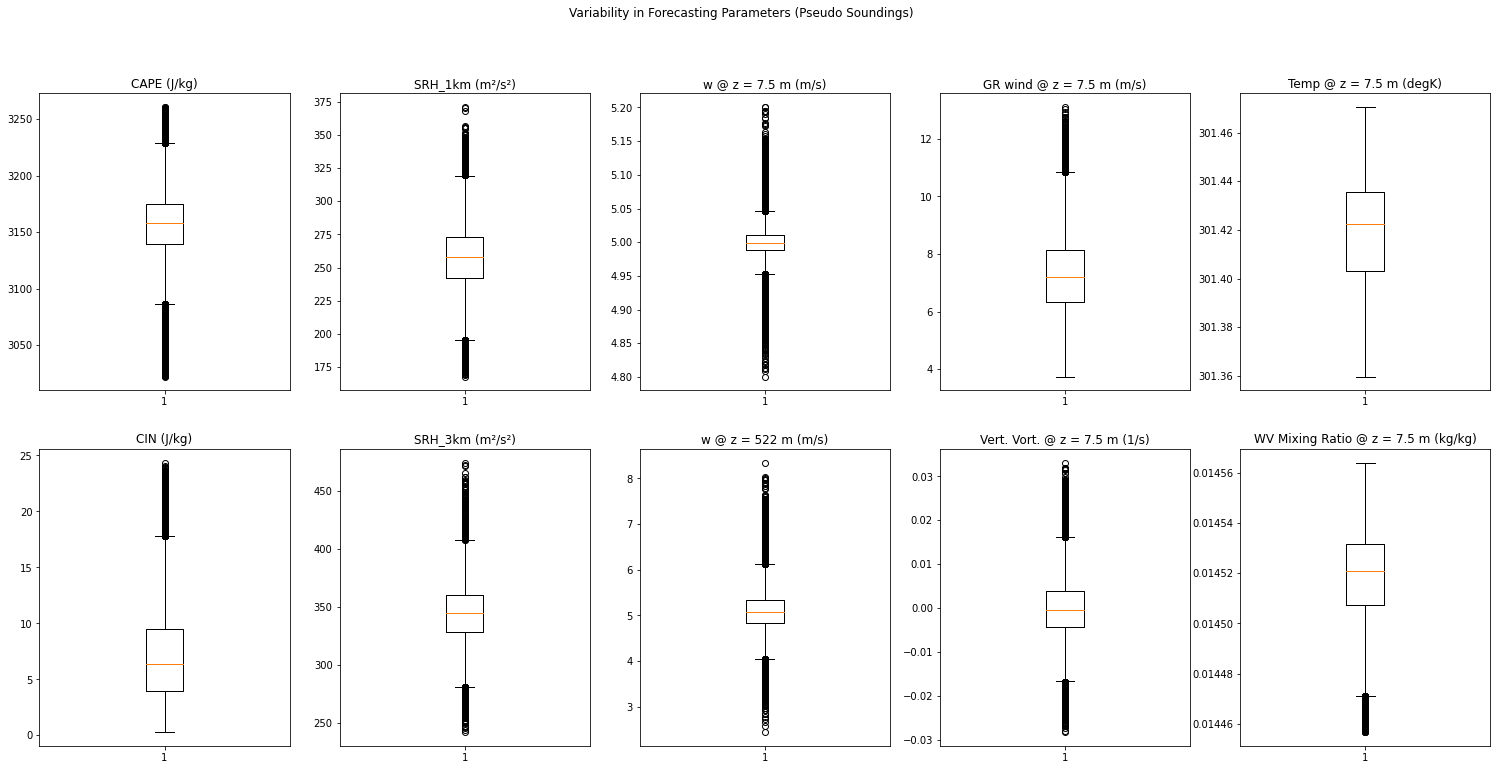

In [6]:
#Create A Figure With All Boxplots with Outliers Included

fig, axs = plt.subplots(nrows = 2, ncols = 5, figsize = (26,12))

fig.suptitle('Variability in Forecasting Parameters (Pseudo Soundings)')

#CAPE 
axs[0,0].boxplot(CAPE[0])
axs[0,0].set_title('CAPE (J/kg)')

#CIN
axs[1,0].boxplot(CIN[0])
axs[1,0].set_title('CIN (J/kg)')

#SRH1km 
axs[0,1].boxplot(SRH1km)
axs[0,1].set_title('SRH_1km (m\u00b2/s\u00b2)')

#SRH3km
axs[1,1].boxplot(SRH3km)
axs[1,1].set_title('SRH_3km (m\u00b2/s\u00b2)')

#w @ z = 7.5 m
axs[0,2].boxplot(w[0])
axs[0,2].set_title('w @ z = 7.5 m (m/s)')

#w @ z = 522 m
axs[1,2].boxplot(w[17])
axs[1,2].set_title('w @ z = 522 m (m/s)')

#Ground Relative Wind @ z = 7.5m
axs[0,3].boxplot(gr_wind)
axs[0,3].set_title('GR wind @ z = 7.5 m (m/s)')

#Vertical Vorticity @ z = 7.5 m
axs[1,3].boxplot(zvort[0])
axs[1,3].set_title('Vert. Vort. @ z = 7.5 m (1/s)')

#Temperature @ z = 7.5 m
axs[0,4].boxplot(T[0])
axs[0,4].set_title('Temp @ z = 7.5 m (degK)')

#WV mixing ratio @ z = 7.5 m
axs[1,4].boxplot(qv[0])
axs[1,4].set_title('WV Mixing Ratio @ z = 7.5 m (kg/kg)')

Text(0.5, 1.0, 'WV Mixing Ratio @ z = 7.5 m (kg/kg)')

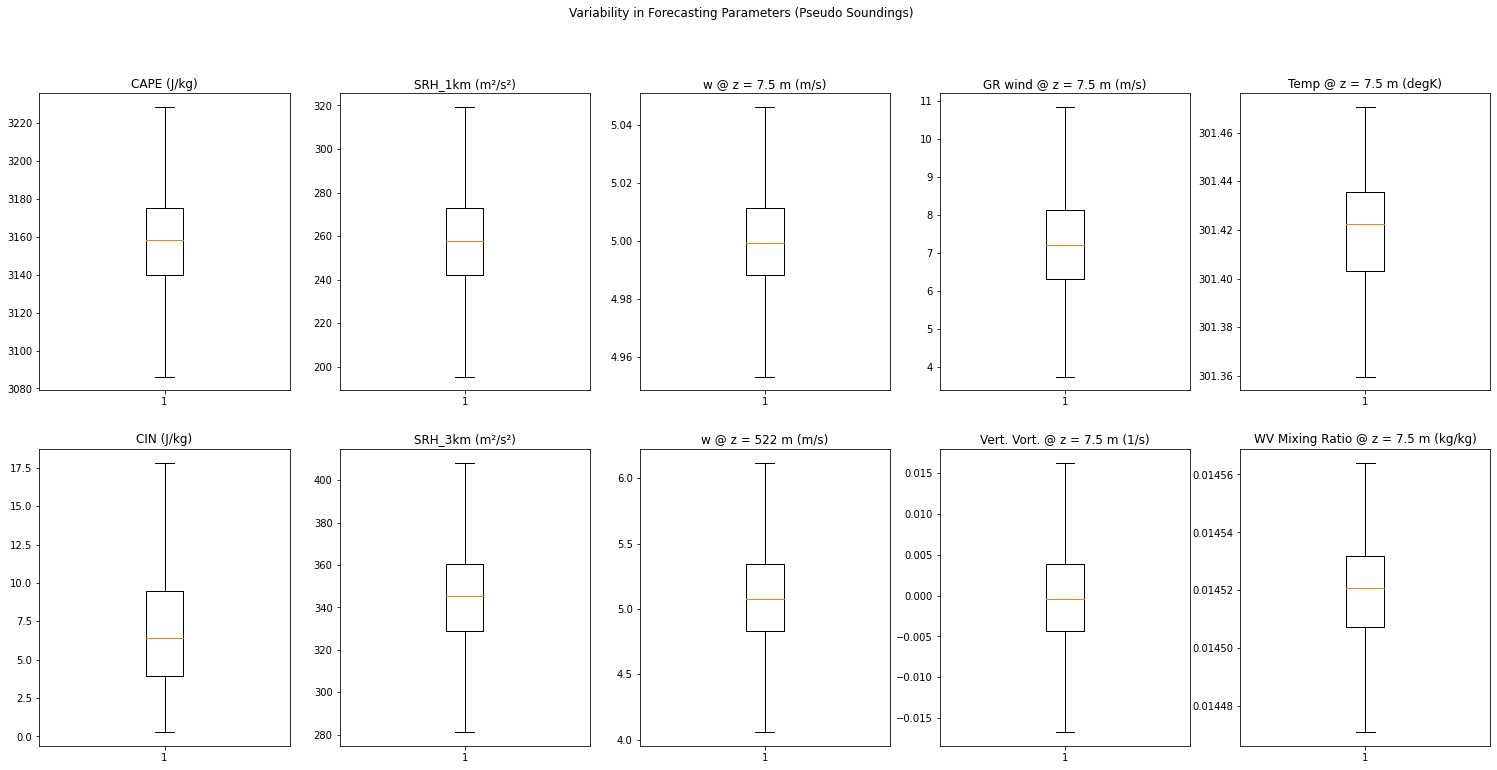

In [7]:
#Create A Figure With All Boxplots without Outliers Included

fig, axs = plt.subplots(nrows = 2, ncols = 5, figsize = (26,12))

fig.suptitle('Variability in Forecasting Parameters (Pseudo Soundings)')

#CAPE 
axs[0,0].boxplot(CAPE[0],0,'')
axs[0,0].set_title('CAPE (J/kg)')

#CIN
axs[1,0].boxplot(CIN[0],0,'')
axs[1,0].set_title('CIN (J/kg)')

#SRH1km 
axs[0,1].boxplot(SRH1km,0,'')
axs[0,1].set_title('SRH_1km (m\u00b2/s\u00b2)')

#SRH3km
axs[1,1].boxplot(SRH3km,0,'')
axs[1,1].set_title('SRH_3km (m\u00b2/s\u00b2)')

#w @ z = 7.5 m
axs[0,2].boxplot(w[0],0,'')
axs[0,2].set_title('w @ z = 7.5 m (m/s)')

#w @ z = 522 m
axs[1,2].boxplot(w[17],0,'')
axs[1,2].set_title('w @ z = 522 m (m/s)')

#Ground Relative Wind @ z = 7.5m
axs[0,3].boxplot(gr_wind,0,'')
axs[0,3].set_title('GR wind @ z = 7.5 m (m/s)')

#Vertical Vorticity @ z = 7.5 m
axs[1,3].boxplot(zvort[0],0,'')
axs[1,3].set_title('Vert. Vort. @ z = 7.5 m (1/s)')

#Temperature @ z = 7.5 m
axs[0,4].boxplot(T[0],0,'')
axs[0,4].set_title('Temp @ z = 7.5 m (degK)')

#WV mixing ratio @ z = 7.5 m
axs[1,4].boxplot(qv[0],0,'')
axs[1,4].set_title('WV Mixing Ratio @ z = 7.5 m (kg/kg)')




In [8]:
#Create Correlation Matrix

#Assemble the Data
data = {
    'CAPE':CAPE[0],
    'CIN':CIN[0],
    'SRH1km':SRH1km,
    'SRH3km':SRH3km,
    'w_75':w[0],
    'w_522':w[17],
    'gr_wind':gr_wind,
    'zvort':zvort[0],
    'T':T[0],
    'qv':qv[0]
}

dataframe = pd.DataFrame(data, columns=['CAPE','CIN','SRH1km','SRH3km','w_75','w_522','gr_wind','zvort','T','qv'])

#Create the Matrix
matrix = dataframe.corr()
matrix

,CAPE,CIN,SRH1km,SRH3km,w_75,w_522,gr_wind,zvort,T,qv
CAPE,1.000000,-0.054548,0.169801,0.093913,0.005163,0.008009,-0.051977,-0.004179,0.387416,-0.109128
CIN,-0.054548,1.000000,0.030145,-0.326763,-0.035609,-0.202103,0.082709,-0.010018,-0.213592,-0.066274
SRH1km,0.169801,0.030145,1.000000,0.874351,0.257912,0.003737,-0.638778,-0.005676,0.086268,0.195440
SRH3km,0.093913,-0.326763,0.874351,1.000000,0.261213,0.101304,-0.641640,-0.004932,0.092583,0.243784
w_75,0.005163,-0.035609,0.257912,0.261213,1.000000,0.107597,-0.394191,0.240954,-0.021312,0.024741
w_522,0.008009,-0.202103,0.003737,0.101304,0.107597,1.000000,-0.126470,0.011959,-0.099404,0.096953
gr_wind,-0.051977,0.082709,-0.638778,-0.641640,-0.394191,-0.126470,1.000000,0.038675,0.173538,-0.422657
zvort,-0.004179,-0.010018,-0.005676,-0.004932,0.240954,0.011959,0.038675,1.000000,0.038515,-0.063430
T,0.387416,-0.213592,0.086268,0.092583,-0.021312,-0.099404,0.173538,0.038515,1.000000,-0.657249
qv,-0.109128,-0.066274,0.195440,0.243784,0.024741,0.096953,-0.422657,-0.063430,-0.657249,1.000000


# Box & Whisker Plots and Correlation Matrix: Instantaneous Data

In [9]:
#Read Instantaneousinst_data

path = '/storage/work/bsh5393/Masters Thesis/Near-Storm PseudoSoundings/Data/'
inst_data = np.load(path+'instantaneous_data.npz')
points_data = np.load(path+'interpolation_2_rawtrajectories.npz')

inst_P = inst_data['P']
inst_T = inst_data['T']
inst_Td = inst_data['Td']
inst_Th = inst_data['Th']
inst_qv = inst_data['qv']
inst_u = inst_data['u']
inst_v = inst_data['v']
inst_w = inst_data['w']
inst_zvort = inst_data['zvort']
inst_parc_T = inst_data['parc_T']
inst_CAPE = inst_data['CAPE']
inst_CIN = inst_data['CIN']
inst_SRH1km = inst_data['SRH1km']
inst_SRH3km = inst_data['SRH3km']

#Original Trajectory Points
points = points_data['interp_points']

#Ground Relative Winds
offset_u = 12.2
offset_v = 12.5 
gr_u = inst_u[0]+offset_u
gr_v = inst_v[0]+offset_v
inst_gr_wind = np.sqrt((gr_u**2)+(gr_v**2))

Text(0.5, 1.0, 'WV Mixing Ratio @ z = 7.5 m (kg/kg)')

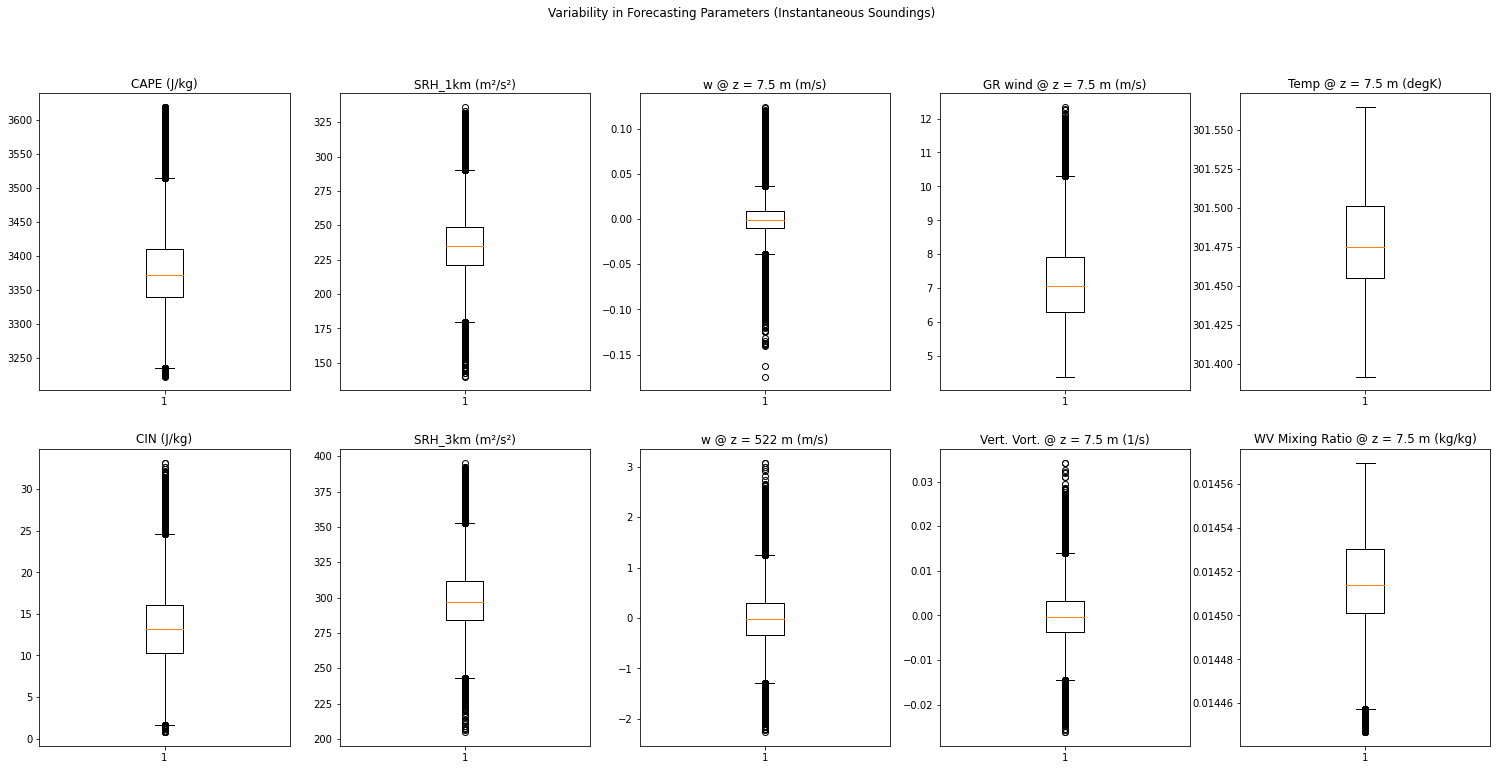

In [10]:
#Create A Figure With All Boxplots with Outliers Included

fig, axs = plt.subplots(nrows = 2, ncols = 5, figsize = (26,12))

fig.suptitle('Variability in Forecasting Parameters (Instantaneous Soundings)')


#CAPE 
axs[0,0].boxplot(inst_CAPE[0])
axs[0,0].set_title('CAPE (J/kg)')

#CIN
axs[1,0].boxplot(inst_CIN[0])
axs[1,0].set_title('CIN (J/kg)')

#SRH1km 
axs[0,1].boxplot(inst_SRH1km)
axs[0,1].set_title('SRH_1km (m\u00b2/s\u00b2)')

#SRH3km
axs[1,1].boxplot(inst_SRH3km)
axs[1,1].set_title('SRH_3km (m\u00b2/s\u00b2)')

#w @ z = 7.5 m
axs[0,2].boxplot(inst_w[0])
axs[0,2].set_title('w @ z = 7.5 m (m/s)')

#w @ z = 522 m
axs[1,2].boxplot(inst_w[17])
axs[1,2].set_title('w @ z = 522 m (m/s)')

#Ground Relative Wind @ z = 7.5m
axs[0,3].boxplot(inst_gr_wind)
axs[0,3].set_title('GR wind @ z = 7.5 m (m/s)')

#Vertical Vorticity @ z = 7.5 m
axs[1,3].boxplot(inst_zvort[0])
axs[1,3].set_title('Vert. Vort. @ z = 7.5 m (1/s)')

#Temperature @ z = 7.5 m
axs[0,4].boxplot(inst_T[0])
axs[0,4].set_title('Temp @ z = 7.5 m (degK)')

#WV mixing ratio @ z = 7.5 m
axs[1,4].boxplot(inst_qv[0])
axs[1,4].set_title('WV Mixing Ratio @ z = 7.5 m (kg/kg)')


Text(0.5, 1.0, 'WV Mixing Ratio @ z = 7.5 m (kg/kg)')

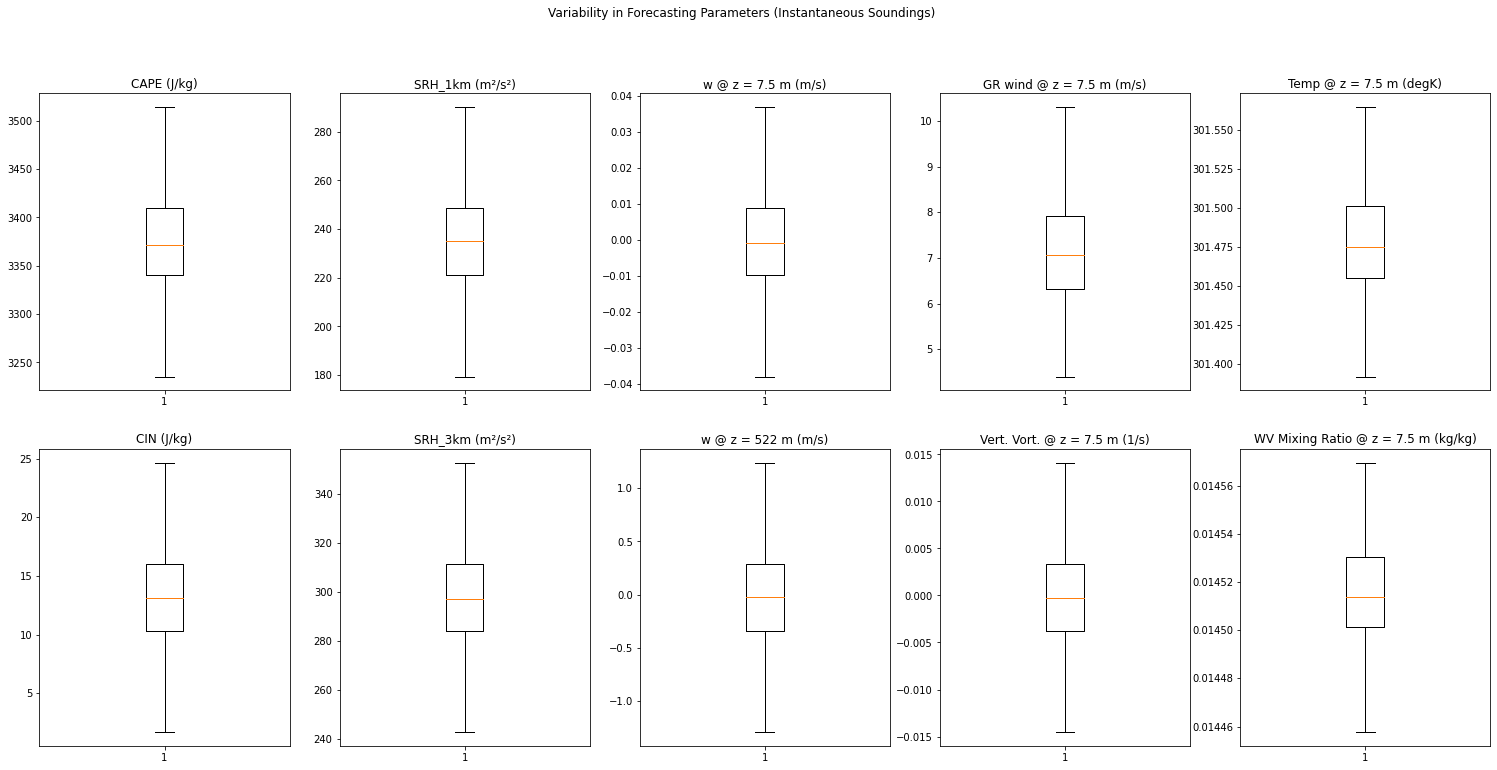

In [11]:
#Create A Figure With All Boxplots without Outliers Included

fig, axs = plt.subplots(nrows = 2, ncols = 5, figsize = (26,12))

fig.suptitle('Variability in Forecasting Parameters (Instantaneous Soundings)')

#CAPE 
axs[0,0].boxplot(inst_CAPE[0],0,'')
axs[0,0].set_title('CAPE (J/kg)')

#CIN
axs[1,0].boxplot(inst_CIN[0],0,'')
axs[1,0].set_title('CIN (J/kg)')

#SRH1km 
axs[0,1].boxplot(inst_SRH1km,0,'')
axs[0,1].set_title('SRH_1km (m\u00b2/s\u00b2)')

#SRH3km
axs[1,1].boxplot(inst_SRH3km,0,'')
axs[1,1].set_title('SRH_3km (m\u00b2/s\u00b2)')

#w @ z = 7.5 m
axs[0,2].boxplot(inst_w[0],0,'')
axs[0,2].set_title('w @ z = 7.5 m (m/s)')

#w @ z = 522 m
axs[1,2].boxplot(inst_w[17],0,'')
axs[1,2].set_title('w @ z = 522 m (m/s)')

#Ground Relative Wind @ z = 7.5m
axs[0,3].boxplot(inst_gr_wind,0,'')
axs[0,3].set_title('GR wind @ z = 7.5 m (m/s)')

#Vertical Vorticity @ z = 7.5 m
axs[1,3].boxplot(inst_zvort[0],0,'')
axs[1,3].set_title('Vert. Vort. @ z = 7.5 m (1/s)')

#Temperature @ z = 7.5 m
axs[0,4].boxplot(inst_T[0],0,'')
axs[0,4].set_title('Temp @ z = 7.5 m (degK)')

#WV mixing ratio @ z = 7.5 m
axs[1,4].boxplot(inst_qv[0],0,'')
axs[1,4].set_title('WV Mixing Ratio @ z = 7.5 m (kg/kg)')

In [12]:
#Create Correlation Matrix

#Assemble the Data
data = {
    'CAPE':inst_CAPE[0],
    'CIN':inst_CIN[0],
    'SRH1km':inst_SRH1km,
    'SRH3km':inst_SRH3km,
    'w_75':inst_w[0],
    'w_522':inst_w[17],
    'gr_wind':inst_gr_wind,
    'zvort':inst_zvort[0],
    'T':inst_T[0],
    'qv':inst_qv[0]
}

dataframe = pd.DataFrame(data, columns=['CAPE','CIN','SRH1km','SRH3km','w_75','w_522','gr_wind','zvort','T','qv'])

#Create the Matrix
matrix = dataframe.corr()

matrix

,CAPE,CIN,SRH1km,SRH3km,w_75,w_522,gr_wind,zvort,T,qv
CAPE,1.000000,-0.139797,-0.087888,-0.060326,0.008198,0.011816,-0.015663,-0.007740,0.296442,-0.174318
CIN,-0.139797,1.000000,0.175052,-0.197000,-0.030699,-0.123746,0.000719,-0.021830,-0.319448,0.321066
SRH1km,-0.087888,0.175052,1.000000,0.885089,0.291367,-0.017101,-0.599376,-0.043376,-0.169352,0.093636
SRH3km,-0.060326,-0.197000,0.885089,1.000000,0.302613,0.027508,-0.592867,-0.037484,0.005826,-0.046979
w_75,0.008198,-0.030699,0.291367,0.302613,1.000000,0.114775,-0.427986,0.181926,-0.010610,0.025815
w_522,0.011816,-0.123746,-0.017101,0.027508,0.114775,1.000000,-0.070880,-0.005012,-0.002937,0.022172
gr_wind,-0.015663,0.000719,-0.599376,-0.592867,-0.427986,-0.070880,1.000000,0.021881,0.210791,-0.314201
zvort,-0.007740,-0.021830,-0.043376,-0.037484,0.181926,-0.005012,0.021881,1.000000,0.020259,-0.043761
T,0.296442,-0.319448,-0.169352,0.005826,-0.010610,-0.002937,0.210791,0.020259,1.000000,-0.840516
qv,-0.174318,0.321066,0.093636,-0.046979,0.025815,0.022172,-0.314201,-0.043761,-0.840516,1.000000


# Now Combine Pseudo and Instantaneous 

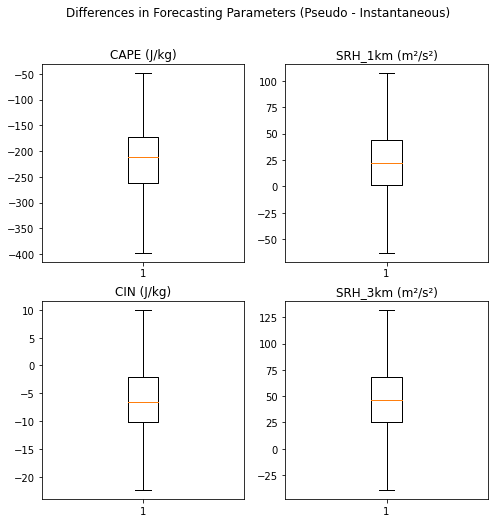

In [13]:
#Plot the Variability in The Differences Between Pseudo - Instantaneous Data Pointwise

#Create A Figure With All Boxplots without Outliers Included

fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8,8))

fig.suptitle('Differences in Forecasting Parameters (Pseudo - Instantaneous)')

#CAPE 
axs[0,0].boxplot([CAPE[0] - inst_CAPE[0]], 0,'')
axs[0,0].set_title('CAPE (J/kg)')

#CIN
axs[1,0].boxplot([CIN[0] - inst_CIN[0]], 0,'')
axs[1,0].set_title('CIN (J/kg)')

#SRH1km 
axs[0,1].boxplot([SRH1km - inst_SRH1km], 0,'')
axs[0,1].set_title('SRH_1km (m\u00b2/s\u00b2)')

#SRH3km
axs[1,1].boxplot([SRH3km - inst_SRH3km], 0,'')
axs[1,1].set_title('SRH_3km (m\u00b2/s\u00b2)')

#w @ z = 7.5 m
#axs[0,2].boxplot([w[0] - inst_w[0]], 0,'')
#axs[0,2].set_title('w @ z = 7.5 m (m/s)')

#w @ z = 522 m
#axs[1,2].boxplot([w[17] - inst_w[17]], 0,'')
#axs[1,2].set_title('w @ z = 522 m (m/s)')

#Ground Relative Wind @ z = 7.5m
#axs[0,3].boxplot([gr_wind - inst_gr_wind], 0,'')
#axs[0,3].set_title('GR wind @ z = 7.5 m (m/s)')

#Vertical Vorticity @ z = 7.5 m
#axs[1,3].boxplot([zvort[0] - inst_zvort[0]], 0,'')
#axs[1,3].set_title('Vert. Vort. @ z = 7.5 m (1/s)')

#Temperature @ z = 7.5 m
#axs[0,4].boxplot([T[0] - inst_T[0]], 0,'')
#axs[0,4].set_title('Temp @ z = 7.5 m (degK)')

#WV mixing ratio @ z = 7.5 m
#axs[1,4].boxplot([qv[0] - inst_qv[0]], 0,'')
#axs[1,4].set_title('WV Mixing Ratio @ z = 7.5 m (kg/kg)')

#Save the plot
path = '/storage/work/bsh5393/Variability Study/Sensitivity Analysis/Figures/'
image_filename = 'diff_with_outliers.png'
fig.savefig(path + image_filename)


# Plot the Differences at Each Height Level

In [14]:
#Try to Create A BoxPlot at each height level for the differences between pseudo and instantaneous soundings for chosen variable
#Pseudo-Instantaneous


#DataFrame Dimensions
num_levels, num_data = P.shape
revised_num_levels = 27 #Only include up to about 1km above surface

# Creating the DataFrame
df = pd.DataFrame({
    'Height Level': [str(round(z_data.values[i],2)) for i in range(revised_num_levels)],
    'diff_P': [(P[i] - inst_P[i]).tolist() for i in range(revised_num_levels)],
    'diff_T': [(T[i] - inst_T[i]).tolist() for i in range(revised_num_levels)],
    'diff_Td': [(Td[i] - inst_Td[i]).tolist() for i in range(revised_num_levels)],
    'diff_Th': [(Th[i] - inst_Th[i]).tolist() for i in range(revised_num_levels)],
    'diff_qv': [(qv[i] - inst_qv[i]).tolist() for i in range(revised_num_levels)],
    'diff_u': [(u[i] - inst_u[i]).tolist() for i in range(revised_num_levels)],
    'diff_v': [(v[i] - inst_v[i]).tolist() for i in range(revised_num_levels)],
    'diff_w': [(w[i] - inst_w[i]).tolist() for i in range(revised_num_levels)],
    'diff_zvort': [(zvort[i] - inst_zvort[i]).tolist() for i in range(revised_num_levels)],
    'diff_parc_T': [(parc_T[i] - inst_parc_T[i]).tolist() for i in range(revised_num_levels)],
})

# Converting to long-form DataFrame
df_long = df.melt(id_vars=['Height Level'], var_name='Difference Type', value_name='Value')
df_long = df_long.explode('Value').reset_index(drop=True)

In [15]:
#Create and Save a BoxPlot
def boxplot(var_name):
    #Isolate The Variable
    df_diff = df_long[df_long['Difference Type'] == var_name]
    fig = plt.figure(figsize=(10, 20))  # Adjust the figure size if necessary
    sns.boxplot(x='Value', y='Height Level',data=df_diff, orient='h',fliersize = 0)
    # Set labels and title
    plt.xlabel(f'{var_name}')
    plt.ylabel('Height Level (km)')
    plt.title(f'Horizontal Boxplot for {var_name} (Pseudo-Instantaneous)')
    plt.gca().invert_yaxis()
    #Save the plot
    path = '/storage/work/bsh5393/Masters Thesis/Near-Storm PseudoSoundings/Figures/'
    image_filename = f'{var_name}.png'
    fig.savefig(path + image_filename)
    #clear 
    plt.close()

In [16]:
#Create A Boxplot for Each Variable

for name in tqdm(df.columns[1:]):
    boxplot(name)

100%|██████████| 10/10 [02:29<00:00, 14.96s/it]
